<a target="_blank" href="https://colab.research.google.com/github/lamm-mit/ModeShapeDiffusionDesign/blob/main/colab_demo/Inference_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 0. Preparation:
### 0-1. Add packages

In [1]:
#@title ####Install omegafold

import os,sys
import math

# ++ Model is hosted on HG
from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #turn off CUDA if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# comm_line=f'pip uninstall -y torch torchvision torchaudio torchdata torchtext fastai'
# print(os.popen(comm_line).read())
# comm_line=f'pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113'
# print(os.popen(comm_line).read())
# import torch
# print('Torch version: ', torch.__version__)

path_1 = '/opt/bin/'
dssp_file = path_1+'mkdssp'

file_exists = os.path.exists(dssp_file)
if not (file_exists):
  print('\033[1;32m For the 1st run, ')
  # ==============================================
  print('a. Install omegafold...')
  # install omegafold
  # ref: https://github.com/HeliXonProtein/OmegaFold
  # !pip install git+https://github.com/HeliXonProtein/OmegaFold.git
  !pip install git+https://github.com/Bo-Ni/OmegaFold_0.git

  # # time-consuming step:
  # # Downloading weights from https://helixon.s3.amazonaws.com/release1.pt to /root/.cache/omegafold_ckpt/model.pt
  # !mkdir /root/.cache/omegafold_ckpt
  # !wget https://helixon.s3.amazonaws.com/release1.pt -O /root/.cache/omegafold_ckpt/model.pt

  print('b. Install DSSP...')
  # download an mkdssp
  # ==============================================
  # download things
  #
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename="Model_files/mkdssp",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  # move the file
  print(os.popen(f"mv /content/Model_files/mkdssp {dssp_file}").read())

  #
  !chmod u+x /opt/bin/mkdssp

else:
  print('This is not the first run... ')

This is not the first run... 


In [2]:
#@title ####Install other additional packages
# add some packages
try:
  print('\033[1;32m a. on Biopython...')
  from Bio.PDB import PDBParser
except ImportError as e:
  print(os.popen('pip install biopython').read())

try:
  print('\033[1;32m b. on kornia...')
  import kornia.augmentation
except ImportError as e:
  print(os.popen('pip install kornia').read())

try:
  print('\033[1;32m c. on einops...')
  from einops import rearrange, repeat, reduce
except ImportError as e:
  print(os.popen('pip install einops').read())

try:
  from einops_exts import rearrange_many, repeat_many, check_shape
except ImportError as e:
  print(os.popen('pip install einops-exts').read())

try:
  import pytorch_warmup as warmup
except ImportError as e:
  print(os.popen('pip install pytorch-warmup').read())

try:
  from ema_pytorch import EMA
except ImportError as e:
  print(os.popen('pip install ema-pytorch').read())

try:
  from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs
except ImportError as e:
  print(os.popen('pip install accelerate').read())

try:
  import py3Dmol
except ImportError as e:
  print(os.popen('pip install py3Dmol').read())

# added
try:
  import esm
except ImportError as e:
  print(os.popen('pip install fair-esm').read())

try:
  import torchinfo
except ImportError as e:
  print(os.popen('pip install torchinfo').read())

try:
  import beartype
except ImportError as e:
  print(os.popen('pip install beartype==0.18.5').read())

 a. on Biopython...
 b. on kornia...
 c. on einops...


### 0.2. Get VibeGen from github

In [3]:
#@title #### Model code

import json, time, os, sys, glob

# ===================================================================
# from LAMM
# real one
code_repo = 'https://github.com/lamm-mit/ModeShapeDiffusionDesign.git'

code_dir = '/content/ModeShapeDiffusionDesign/'
#
if not os.path.isdir(code_dir):
  os.system(f"git clone -q {code_repo}")
sys.path.append(code_dir)
#
# check
if not os.path.isdir(code_dir):
  print(f"The package is not downloaded propertly. Check your access to the repository {code_repo}")

In [4]:
#@title #### Light test
# a slient test
#
# working packages

import VibeGen.UtilityPack as UPack

import VibeGen.DataSetPack as DPack

import VibeGen.ModelPack as MPack

import VibeGen.TrainerPack as TPack

import VibeGen.JointSamplingPack as SPack

### 0.3. Download the model files

In [6]:
#@title #### Set up the saved model

# just script, no install is used
# this_working_path = '/content/working_results/'
trained_duo_dir='/content/trained_duo/'

from huggingface_hub import snapshot_download

if os.path.exists(trained_duo_dir):
    UPack.Print(f"Path already exits. Use Caution...")
else:
    UPack.Print(f"Create dir for trained model...")
    UPack.create_path(trained_duo_dir)
    #
    snapshot_download(
        repo_id="lamm-mit/VibeGen",
        local_dir=trained_duo_dir,
        repo_type="model"
    )

Create dir for trained model...
Creating the given path...
Done.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

ProteinDesigner%2FPD_List.txt:   0%|          | 0.00/227 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model_pack.pickle:   0%|          | 0.00/864 [00:00<?, ?B/s]

Best_ckpt.pt:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

data_pack.pickle:   0%|          | 0.00/19.9M [00:00<?, ?B/s]

Best_ckpt.pt:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

df_test.pk:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Last_ckpt.pt:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

ProteinPredictor%2FPP_List.txt:   0%|          | 0.00/190 [00:00<?, ?B/s]

Last_ckpt.pt:   0%|          | 0.00/4.19G [00:00<?, ?B/s]

data_pack.pickle:   0%|          | 0.00/19.9M [00:00<?, ?B/s]

model_pack.pickle:   0%|          | 0.00/861 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

## 1. Working part

In [7]:
#@title ### 1.0. Check the floor
import os, sys
print('Here is : \n', os.popen('pwd').read())
print('What we get in hardware: \n', os.popen('nvidia-smi').read())

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

print('What hardware the software see:')
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
num_of_gpus = torch.cuda.device_count()
print("# of GPU", num_of_gpus)
print()
torch.cuda.empty_cache()

Here is : 
 /content

What we get in hardware: 
 Thu Feb 13 16:30:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |

In [9]:
#@title ### 1.1. Setup the problem
# prepare for package debugging
# for debug


# general packages

import importlib
# on data
import pickle
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
from einops import rearrange

# global setup: control keys

# for debug
CKeys = dict(
    Working_Mode='Sampling', #
    n_try_w_PD=20,
    n_keep_w_PP=2,
    PD_cond_scal=1.0,
    PP_cond_scal=1.0,
    #
    Debug=1,
    # 1: showing middle results
    # 0: skip middle results
    #
    # #
    # Debug_Datakey=1,
    # Debug_Sampling=1,
    #
    wk_dir='/content/wk_dir/',
    trained_duo_dir='/content/trained_duo/',
)

# some secondary ones
if CKeys['Debug']==1:

    # debug run

    CKeys['Debug_Datakey']=1
    CKeys['Debug_Sampling']=1

    CKeys['SilentRun']=0

else:
    # silent run

    CKeys['Debug_Datakey']=0
    CKeys['Debug_Sampling']=0

    CKeys['SilentRun']=1

# setup the folders
#
if os.path.exists(CKeys['wk_dir']):
    UPack.Print(f"Path already exits. Use Caution...")
else:
    UPack.Print(f"Create wkring path...")
    UPack.create_path(CKeys['wk_dir'])
    #

# global setup: control keys for PD and PP
#
PD_CKeys = dict(
    #
    Working_Mode=3,
    # 0-prepare dataloader; 1-training; 2-sampling; 3-sampling from remote
    #
    IF_FirstRun=1,  # 1-1st run of training; otherwise, resume of previous training
    #
    #
    Resume_from_where='LAST',
    # 'BEST',
    # 'LAST',
    #
    Problem_ID=1,
    # 1: Designer: from MD NMS vector to Sequence
    #

    # Debug keys
    Debug=1, # 1-turn on debug mode; 0-working mode
)

PP_CKeys = dict(
    #
    Working_Mode=3,
    # 0-prepare dataloader; 1-training; 2-sampling; 3-sampling from remote
    #
    IF_FirstRun=2, # 1,  # 1-1st run of training; otherwise, resume of previous training
    #
    #
    Resume_from_where='LAST',
    # 'BEST',
    # 'LAST',
    #
    Problem_ID=2,
    # 1: Designer: from MD NMS vector to Sequence
    #
    # 2: Predictor: map sequence to NMS. Inside the
    #
    # Debug keys
    Debug=1, # 1-turn on debug mode; 0-working mode
)

# setup Debug Keys

# ===================================================

if PD_CKeys['Debug']==1:
    #
    PD_CKeys['SilentRun'] = 0 # 0-show all figures; 1-save figures wo/ showing
    # detailed debug key
    # may set multiple times as needed
    # 1. for data and model parts
    PD_CKeys['Debug_DataPack'] = 1
    PD_CKeys['Debug_ModelPack'] = 1
    PD_CKeys['Debug_TrainlPack'] = 1

    # 2. for trainer part
    PD_CKeys['Debug_DataPack'] = 0
    PD_CKeys['Debug_ModelPack'] = 0
    PD_CKeys['Debug_TrainlPack'] = 0

    # Debug_Level_UNet = 0
    # Debug_Level_DP = 0

    # others
    PD_CKeys['testset_raio'] = 0.10
else:
    # setup keys for real run

    PD_CKeys['Debug_DataPack'] = 0
    PD_CKeys['Debug_ModelPack'] = 0
    PD_CKeys['Debug_TrainlPack'] = 0

    PD_CKeys['SilentRun'] = 1

    # others
    PD_CKeys['testset_raio'] = 0.10

    pass

# ====================================================

if PP_CKeys['Debug']==1:
    #
    PP_CKeys['SilentRun'] = 0 # 0-show all figures; 1-save figures wo/ showing
    # detailed debug key
    # may set multiple times as needed
    # 1. for data and model parts
    PP_CKeys['Debug_DataPack'] = 1
    PP_CKeys['Debug_ModelPack'] = 1
    PP_CKeys['Debug_TrainlPack'] = 1

    # # 2. for trainer part
    # PP_CKeys['Debug_DataPack'] = 0
    # PP_CKeys['Debug_ModelPack'] = 0
    # PP_CKeys['Debug_TrainlPack'] = 0

    # Debug_Level_UNet = 0
    # Debug_Level_DP = 0

    # others
    PP_CKeys['testset_raio'] = 0.10
else:
    # setup keys for real run

    PP_CKeys['Debug_DataPack'] = 0
    PP_CKeys['Debug_ModelPack'] = 0
    PP_CKeys['Debug_TrainlPack'] = 0

    PP_CKeys['SilentRun'] = 1

    # others
    PP_CKeys['testset_raio'] = 0.10

    pass

# on PD

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# match real run
PD_PKeys = {}

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on data part
PD_PKeys['seq_len'] = 128
PD_PKeys['maxdata'] = 10000000
PD_PKeys['batch_size'] = 256
PD_PKeys['testset_ratio'] = PD_CKeys['testset_raio']

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on model part
PD_PKeys['text_seq_len'] = 128

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on training
PD_PKeys['num_train_epochs'] = 4000 # 1000
PD_PKeys['gradient_accumulation_steps'] = 8

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# store all info for resume running

PD_PKeys['pk_data_pack']  = CKeys['trained_duo_dir']+'/ProteinDesigner/data_pack.pickle'
PD_PKeys['pk_model_pack'] = CKeys['trained_duo_dir']+'/ProteinDesigner/model_pack.pickle'


# on PP

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Parameter keys

PP_PKeys = {}

# PP_root_path = '/nfs/mbuehler001/bo_ni/Test_ground/jupyter/1_git_project/PreNMA_For_Protein_1/Local_Store'
# base path to construct working path
# UPDATE this one if needed

# if PP_CKeys['Debug']==1:
#     # debug mode, perhaps local run
#     # working path
#     PP_PKeys['wk_dir'] = PP_root_path+'/For_PPredictor_at_0_0_1_1_NMA_0/'
#     # name tag
#     PP_PKeys['prefix'] = 'PPredictor_ConTextImg_0'
# else:
#     # working path
#     PP_PKeys['wk_dir'] = PP_root_path+'/For_PPredictor_at_0_0_1_1_NMA_1/'
#     # name tag
#     PP_PKeys['prefix'] = 'PPredictor_ConTextImg_0'

# # ===============================================
# # highjack this if needed

# if PP_CKeys['Working_Mode']==3:
#     # --
#     PP_root_path = '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/1_ProteinPredictor_Base_3Mode_PDB_img_tex/'
#     # ++
#     PP_root_path = '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_ProteinPredictor_Base_1Mode_PDB_img_tex/'
#     # working path
#     PP_PKeys['wk_dir'] = PP_root_path+'/resut/' # '/resu/'
#     # name tag
#     PP_PKeys['prefix'] = 'PPredictor_ConTextImg_0'

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# add more for each section: problem specified
# son keys:

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on data part
PP_PKeys['seq_len'] = 128
PP_PKeys['maxdata'] = 10000000
PP_PKeys['batch_size'] = 256
PP_PKeys['testset_ratio'] = PP_CKeys['testset_raio']

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on model part
PP_PKeys['text_seq_len'] = 128

# # ||||||||||||||||||||||||||||||||||||||||||||||||||||||
# #  on training
PP_PKeys['num_train_epochs'] = 4000 # 1000
PP_PKeys['gradient_accumulation_steps'] = 8

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# fixed block

# store all info for resume running

PP_PKeys['pk_data_pack']  = CKeys['trained_duo_dir']+'/ProteinPredictor/data_pack.pickle'
PP_PKeys['pk_model_pack'] = CKeys['trained_duo_dir']+'/ProteinPredictor/model_pack.pickle'



## on dataset

# PD

if PD_CKeys['Working_Mode']>0:

    print('This is not the first data preparation run...')
    print('Load back in the data packages...')



    PD_DataKeys={}
    # PD_DataKeys['data_dir']='/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/5_ProteinDesigner_Base_1Mode_PDB_img_tex_slower//resu/0_DataProcess_MD/'
    PD_DataKeys['maxdata']=10000000
    PD_DataKeys['batch_size']=256
    PD_DataKeys['testset_ratio']= 0.1
    PD_DataKeys['min_AA_seq_len']= 0
    PD_DataKeys['max_AA_seq_len']= 128
    PD_DataKeys['max_used_Seg_Num']= 1
    PD_DataKeys['X_Key']= ['Mode7_NormDisAmp']
    PD_DataKeys['X_mode_num']= 1
    PD_DataKeys['ESM-2_Model']= 'esm2_t30_150M_UR50D'
    PD_DataKeys['image_channels']= 33
    PD_DataKeys['Xnormfac']= [9.513197412136874]
    PD_DataKeys['ynormfac']= 1.0
    PD_DataKeys['tokenizer_X']= None
    PD_DataKeys['tokenizer_y']= None

    if PD_CKeys['Problem_ID']==1:
        # PD_protein_df = pd.read_pickle(PD_DataKeys['data_dir']+'protein_df.pk')
        # PD_df_raw = pd.read_pickle(PD_DataKeys['data_dir']+'df_raw.pk')
        # # ++
        # PD_df_train = pd.read_pickle(PD_DataKeys['data_dir']+'df_train.pk')
        # PD_df_test = pd.read_pickle(PD_DataKeys['data_dir']+'df_test.pk')
        # ++
        PD_df_test = pd.read_pickle(
            CKeys['trained_duo_dir']+'/ProteinDesigner/'+'df_test.pk'
        )

    # check the key
    UPack.print_dict_content(
        PD_DataKeys
    )

    print('Done.')


# PP

if PP_CKeys['Working_Mode']>0:

    # --
    print('This is not the first data preparation run...')
    print('Load back in the data packages...')



    # ++
    PP_DataKeys = {}
    # PP_CKeys['data_dir']= '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/0_DataProcess_MD/'
    PP_DataKeys['maxdata']= 10000000
    PP_DataKeys['batch_size']= 256
    PP_DataKeys['testset_ratio']= 0.1
    PP_DataKeys['min_AA_seq_len']= 0
    PP_DataKeys['max_AA_seq_len']= 128
    PP_DataKeys['max_used_Seg_Num']= 1
    PP_DataKeys['X_Key']= ['Mode7_NormDisAmp']
    PP_DataKeys['X_mode_num']= 1
    PP_DataKeys['ESM-2_Model']= 'esm2_t30_150M_UR50D'
    PP_DataKeys['image_channels']= 33
    PP_DataKeys['Xnormfac']= [9.513197412136874]
    PP_DataKeys['ynormfac']= 1.0
    PP_DataKeys['tokenizer_X']= None
    PP_DataKeys['tokenizer_y']= None
    # check the key
    UPack.print_dict_content(
        PP_DataKeys
    )
    print('Done.')


# on model

# PD

if PD_CKeys['Working_Mode']>0:

    # --
    # this can be: 2nd training run or test run
    # load in the keys

    UPack.Print("==========================================")
    UPack.Print ('This is not the first run')
    UPack.Print ('Load back in the model packages...')
    UPack.Print("==========================================")



    # ++
    PD_ModelKeys = {
        'model_dir': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/5_ProteinDesigner_Base_1Mode_PDB_img_tex_slower//resu/1_model_SS/',
        'model_dir_sample': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/5_ProteinDesigner_Base_1Mode_PDB_img_tex_slower//resu/1_model_SS/0_mid_sample/',
        'model_dir_model': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/5_ProteinDesigner_Base_1Mode_PDB_img_tex_slower//resu/1_model_SS/1_store_model/',
        'text_con_embed_dim': 768,
        'text_pos_embed_dim': 32,
        'text_seq_len': 128,
        'UNet_cond_images_channels': 1,
        'UNet_channels': 33,
        'UNet_dim': 256,
        'UNet_lowres_cond': False,
        'UNet_self_cond': True,
        'UNet_text_embed_dim': 800,
        'EImg_seq_size': 128,
        'EImg_cond_drop_prob': 0.1,
        'EImg_sample_step': 96,
        'text_embed_AsInPut_dim': 1
    }
    UPack.Print(f"\nModelKeys: \n{PD_ModelKeys}")

if PD_CKeys['Working_Mode']>0:

    UPack.Print ("=========================================")
    UPack.Print ("Initialize the model from the scratch...")
    UPack.Print ("=========================================")

    UPack.Print ("1. On UNet...")
    UPack.Print ("Only use ModelKeys unless you want to overwrite some")

    PD_wk_unet =  MPack.Unet_OneD(
        # 1. in-out channels
        channels = PD_ModelKeys['UNet_channels'],

        # 2. on initial convolution: CrossEmbLayer
        # 2.1 input dim
        lowres_cond = PD_ModelKeys['UNet_lowres_cond'],
        # if used, GT will be first low-res-ed, then noised and provided as input conditioning
        self_cond = PD_ModelKeys['UNet_self_cond'],
        # self-conditioning
        cond_images_channels = PD_ModelKeys['UNet_cond_images_channels'], # ModelKeys['UNet_channels']
        # use this to triger conditioning image if this>0

        # 2.3 layer structure
        init_cross_embed = True,       # use CrossEmbedLayer otherwise just Conv
        init_cross_embed_kernel_sizes = (3, 7, 15), # if CrossEmbedLayer is used
        init_conv_kernel_size = 7,                  # kernel size of initial conv, if not using cross embed

        # 3. prepare embedding
        # 3.1 on time_hiddens, time_cond, time_tokens
        dim = PD_ModelKeys['UNet_dim'],  # 256, emb_dim inside UNet
        # use default ones
        dim_mults=(1, 2, 4, 8),        # in ResNet, chang seq len or image H W
        learned_sinu_pos_emb_dim = 16, # pos emb dim
        num_time_tokens = 2,           # num of time tokens
        # 3.2 on lowres_cond
        # 3.3 on text conditioning:
        text_embed_dim = PD_ModelKeys['UNet_text_embed_dim'], #
        # 768,          # get_encoded_dim(DEFAULT_T5_NAME), now text_embed_dim+text_pos_embed_dim
        # finer control over whether to condition on text encodings
        cond_on_text = True,
        # if activate Perceiver re-sampler
        attn_pool_text = True,         # activate Perceiver re-sampler if true
        attn_dim_head = 64,            # attation head dim
        attn_heads = 8,                # attation head number
        attn_pool_num_latents = 32,    # num_latents
        # for classifier free guidance
        max_text_len = PD_ModelKeys['text_seq_len'], # 256,

        # ResNet parts
        num_resnet_blocks = 1,         #? may increase, num of ResNet blocks
        layer_attns = (False, True, True, True), # True,
        layer_attns_depth = 1,         #? may increase,
        layer_cross_attns = (False, True, True, True), # True,
        # choose regular attension or linear attension
        use_linear_attn = False,       # as the seq len is not too large, turn this off
        use_linear_cross_attn = False,
        cross_embed_downsample = True, # default as False; try this one
        cross_embed_downsample_kernel_sizes = (2, 4),
        memory_efficient = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        # use regular upsample or pixelshuffle_upsample (1d)
        pixel_shuffle_upsample = True,       # may address checkboard artifacts
        # use PixelShuffleUpsample_OneD if True
        ff_mult = 2.,                        # feed forward in down/up-sample attension
        layer_mid_attns_depth = 1,           # middle layers in ResNet
        attend_at_middle = True,             # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        combine_upsample_fmaps = True,      # combine feature maps from all upsample blocks, used in unet squared successfully

        # last part
        init_conv_to_final_conv_residual = False, # whether to do a final residual from initial conv to the final resnet block out
        final_resnet_block = True,
        final_conv_kernel_size = 3,
        resize_mode = 'nearest',

        # others:
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        dropout = 0.,                  # not used, other part use their default dropout

        # debug key
        CKeys = {
            'Debug_Level': 0 # Debug_Level_UNet # CKeys['Debug_ModelPack']
        },

    ).to(device)

    UPack.Print ("2. On Protein Designer...")
    UPack.Print ("..........................................")

    PD_wk_ProteinDesigner = MPack.ProteinDesigner_Base(

        # 1. Diffusion core
        PD_wk_unet,
        elucidated=True, # use Elucidated Imagen; others to be implemented

        # 1.1. on the main obj that passes through the UNet/Diffuser
        seq_obj_max_size=PD_ModelKeys['EImg_seq_size'],  # max AA seq size

        # 1.2 on extra care on text condition;

        # ohter conditioning is passed in via UNet
        text_embed_input_dim = PD_ModelKeys['text_embed_AsInPut_dim'],
        text_con_embed_dim=PD_ModelKeys['text_con_embed_dim'], # 768, # dim of text content embedding
        text_pos_embed_dim=PD_ModelKeys['text_pos_embed_dim'], # 32, # dim for text position embedding
        cond_drop_prob=PD_ModelKeys['EImg_cond_drop_prob'], # 0.1,

        # 2. do diffusion/sampling
        timestep = PD_ModelKeys['EImg_sample_step'], # 10,

        # 3. pretrained pLM
        proteinLanguageModel = PD_DataKeys['ESM-2_Model'], # None, # DataKeys['ESM-2_Model'],

        # ++
        # for debug
        CKeys={
            'Debug_Level': 0 # Debug_Level_DP # CKeys['Debug_ModelPack']
        },

    ).to(device)




# some simple checks

if PD_CKeys['Working_Mode']>0:
    # ++
    UPack.Print(f"Model size: ")

    # UPack.Print(f"Unet: ")
    # UPack.Print_model_params(
    #     PD_wk_unet
    # )

    UPack.Print(f"Protein designer ")
    UPack.Print_model_params(
        # wk_ProteinDesigner
        PD_wk_ProteinDesigner
    )


if PD_CKeys['Working_Mode']>0:
    #
    UPack.Print ("====================================================")
    UPack.Print ("For >1 runs, load-in training hisotry...")
    UPack.Print ("====================================================")
    #
    UPack.Print(f"Load from: {PD_CKeys['Resume_from_where']}\n\n")

    if PD_CKeys['Resume_from_where'] == 'LAST':
        # PD_ckpt_name = PD_TrainKeys['ck_dir_last']+'Last_ckpt.pt'
        PD_ckpt_name = CKeys['trained_duo_dir']+'/ProteinDesigner/'+'Last_ckpt.pt'
    elif PD_CKeys['Resume_from_where'] == 'BEST':
        # PD_ckpt_name = PD_TrainKeys['ck_dir_best']+'Best_ckpt.pt'
        PD_ckpt_name = CKeys['trained_duo_dir']+'/ProteinDesigner/'+'Best_ckpt.pt'

    # ckpt_name = TrainKeys['ck_dir_last']+'Keep_ckpt_292_.pt'
    print ("CK_PT: ", PD_ckpt_name)
    print (f"{os.path.isfile(PD_ckpt_name)}")
    #
    # prepare to resume training from a checkpoint
    PD_checkpoint = torch.load(
        PD_ckpt_name,
        map_location=device, # TrainKeys['device']
    )

    for this_key in PD_checkpoint:
        UPack.Print (this_key)

if PD_CKeys['Working_Mode']>0:
    #
    # Here, for GPT, we use checkpoint to load back the model
    UPack.Print ("Loading the saved model...")

    PD_state_dict = PD_checkpoint['model']
    # if want to take a look
    # for k,v in list(state_dict.items()):
    #     print (k)

    # NOTE, this one has unwanted contents.
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    UPack.Print(f"ori len: {len(PD_state_dict)}")
    unwanted_prefix = '_orig_mod.'
    for k,v in list(PD_state_dict.items()):
        if k.startswith(unwanted_prefix):
            PD_state_dict[k[len(unwanted_prefix):]] = PD_state_dict.pop(k)
    UPack.Print(f"new len: {len(PD_state_dict)}")

    # load back the previous breaking point
    UPack.Print ("Load in the model...")

    PD_wk_ProteinDesigner.load_state_dict(PD_state_dict)

    # get other info
    PD_ck_info = {}
    PD_ck_info['completed_updating_steps'] = PD_checkpoint['completed_updating_steps']
    PD_ck_info['step_num'] = PD_checkpoint['step_num']
    PD_ck_info['iter_num_at_best_loss'] = PD_checkpoint['iter_num_at_best_loss']
    PD_ck_info['best_val_loss'] = PD_checkpoint['best_val_loss']

    UPack.print_dict_content(PD_ck_info)


if PD_CKeys['Working_Mode']>0:
    #
    UPack.Print("May clean up the PD_checkpoint")

    # save some memory
    del PD_state_dict

    del PD_checkpoint

    del PD_wk_unet

    print ("Done")

# PP

if PP_CKeys['Working_Mode']>0:

    # this can be: 2nd training run or test run
    # load in the keys

    UPack.Print("==========================================")
    UPack.Print ('This is not the first run')
    UPack.Print ('Load back in the model packages...')
    UPack.Print("==========================================")



    # ++
    PP_ModelKeys = {
        'model_dir': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/',
        'model_dir_sample': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/0_mid_sample/',
        'model_dir_model': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/1_store_model/',
        'text_con_embed_dim': 640,
        'text_pos_embed_dim': 0,
        'text_seq_len': 128,
        'UNet_cond_images_channels': 33,
        'UNet_channels': 1,
        'UNet_dim': 256,
        'UNet_lowres_cond': False,
        'UNet_self_cond': True,
        'UNet_text_embed_dim': 640,
        'EImg_seq_size': 128,
        'EImg_cond_drop_prob': 0.1,
        'EImg_sample_step': 96,
        'text_embed_AsInPut_dim': 0
    }
    UPack.Print(f"\nModelKeys: \n{PP_ModelKeys}")


if PP_CKeys['Working_Mode']>0:

    UPack.Print ("=========================================")
    UPack.Print ("Initialize the model from the scratch...")
    UPack.Print ("=========================================")

    UPack.Print ("1. On UNet...")
    UPack.Print ("Only use ModelKeys unless you want to overwrite some")

    PP_wk_unet =  MPack.Unet_OneD(
        # 1. in-out channels
        channels = PP_ModelKeys['UNet_channels'],

        # 2. on initial convolution: CrossEmbLayer
        # 2.1 input dim
        lowres_cond = PP_ModelKeys['UNet_lowres_cond'],
        # if used, GT will be first low-res-ed, then noised and provided as input conditioning
        self_cond = PP_ModelKeys['UNet_self_cond'],
        # self-conditioning
        cond_images_channels = PP_ModelKeys['UNet_cond_images_channels'], # ModelKeys['UNet_channels']
        # use this to triger conditioning image if this>0

        # 2.3 layer structure
        init_cross_embed = True,       # use CrossEmbedLayer otherwise just Conv
        init_cross_embed_kernel_sizes = (3, 7, 15), # if CrossEmbedLayer is used
        init_conv_kernel_size = 7,                  # kernel size of initial conv, if not using cross embed

        # 3. prepare embedding
        # 3.1 on time_hiddens, time_cond, time_tokens
        dim = PP_ModelKeys['UNet_dim'],  # 256, emb_dim inside UNet
        # use default ones
        dim_mults=(1, 2, 4, 8),        # in ResNet, chang seq len or image H W
        learned_sinu_pos_emb_dim = 16, # pos emb dim
        num_time_tokens = 2,           # num of time tokens
        # 3.2 on lowres_cond
        # 3.3 on text conditioning:
        text_embed_dim = PP_ModelKeys['UNet_text_embed_dim'], #
        # 768,          # get_encoded_dim(DEFAULT_T5_NAME), now text_embed_dim+text_pos_embed_dim
        # finer control over whether to condition on text encodings
        cond_on_text = True,
        # if activate Perceiver re-sampler
        attn_pool_text = True,         # activate Perceiver re-sampler if true
        attn_dim_head = 64,            # attation head dim
        attn_heads = 8,                # attation head number
        attn_pool_num_latents = 32,    # num_latents
        # for classifier free guidance
        max_text_len = PP_ModelKeys['text_seq_len'], # 256,

        # ResNet parts
        num_resnet_blocks = 1,         #? may increase, num of ResNet blocks
        layer_attns = (False, True, True, True), # True,
        layer_attns_depth = 1,         #? may increase,
        layer_cross_attns = (False, True, True, True), # True,
        # choose regular attension or linear attension
        use_linear_attn = False,       # as the seq len is not too large, turn this off
        use_linear_cross_attn = False,
        cross_embed_downsample = True, # default as False; try this one
        cross_embed_downsample_kernel_sizes = (2, 4),
        memory_efficient = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        # use regular upsample or pixelshuffle_upsample (1d)
        pixel_shuffle_upsample = True,       # may address checkboard artifacts
        # use PixelShuffleUpsample_OneD if True
        ff_mult = 2.,                        # feed forward in down/up-sample attension
        layer_mid_attns_depth = 1,           # middle layers in ResNet
        attend_at_middle = True,             # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        combine_upsample_fmaps = True,      # combine feature maps from all upsample blocks, used in unet squared successfully

        # last part
        init_conv_to_final_conv_residual = False, # whether to do a final residual from initial conv to the final resnet block out
        final_resnet_block = True,
        final_conv_kernel_size = 3,
        resize_mode = 'nearest',

        # others:
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        dropout = 0.,                  # not used, other part use their default dropout

        # debug key
        CKeys = {
            'Debug_Level': 0 # Debug_Level_UNet # CKeys['Debug_ModelPack']
        },

    ).to(device)

    UPack.Print ("2. On Protein Predictor...")
    UPack.Print ("..........................................")

    PP_wk_ProteinPredictor = MPack.ProteinPredictor_Base(

        # 1. Diffusion core
        PP_wk_unet,
        elucidated=True, # use Elucidated Imagen; others to be implemented

        # 1.1. on the main obj that passes through the UNet/Diffuser
        seq_obj_max_size=PP_ModelKeys['EImg_seq_size'],  # max AA seq size

        # 1.2 on extra care on text condition;

        # ohter conditioning is passed in via UNet
        text_embed_input_dim = PP_ModelKeys['text_embed_AsInPut_dim'],
        text_con_embed_dim=PP_ModelKeys['text_con_embed_dim'], # 768, # dim of text content embedding
        text_pos_embed_dim=PP_ModelKeys['text_pos_embed_dim'], # 32, # dim for text position embedding
        cond_drop_prob=PP_ModelKeys['EImg_cond_drop_prob'], # 0.1,

        # 2. do diffusion/sampling
        timestep = PP_ModelKeys['EImg_sample_step'], # 10,

        # 3. pretrained pLM
        proteinLanguageModel = PP_DataKeys['ESM-2_Model'], # None, # DataKeys['ESM-2_Model'],

        # ++
        # for debug
        CKeys={
            'Debug_Level': 0 # Debug_Level_DP # CKeys['Debug_ModelPack']
        },

    ).to(device)


if PP_CKeys['Working_Mode']>0:

    # ++
    UPack.Print(f"Model size: ")

    UPack.Print(f"Protein predictor ")
    UPack.Print_model_params(
        # wk_ProteinDesigner
        PP_wk_ProteinPredictor
    )



# PP

if PP_CKeys['Working_Mode']>0:

    #
    UPack.Print ("====================================================")
    UPack.Print ("For >1 runs, load-in training hisotry...")
    UPack.Print ("====================================================")
    UPack.Print (
        f"Load from: {PP_CKeys['Resume_from_where']}\n\n"
    )
    #
    if PP_CKeys['Resume_from_where'] == 'LAST':
        # PP_ckpt_name = PP_TrainKeys['ck_dir_last']+'Last_ckpt.pt'
        PP_ckpt_name = CKeys['trained_duo_dir']+'/ProteinPredictor/'+'Last_ckpt.pt'
    elif PP_CKeys['Resume_from_where'] == 'BEST':
        PP_ckpt_name = CKeys['trained_duo_dir']+'/ProteinPredictor/'+'Best_ckpt.pt'

    #
    # ckpt_name = TrainKeys['ck_dir_last']+'Keep_ckpt_292_.pt'
    print ("CK_PT: ", PP_ckpt_name)
    print (f"{os.path.isfile(PP_ckpt_name)}")
    #
    # prepare to resume training from a checkpoint
    PP_checkpoint = torch.load(
        PP_ckpt_name,
        map_location=device, # TrainKeys['device']
    )

    for this_key in PP_checkpoint:
        UPack.Print (this_key)




# PP

if PP_CKeys['Working_Mode']>0:

    UPack.Print ("===================================================")
    UPack.Print ("Load back the MODEL if this's not the 1st training.")
    UPack.Print ("===================================================")

    # Here, for GPT, we use checkpoint to load back the model
    UPack.Print ("Loading the saved model...")

    PP_state_dict = PP_checkpoint['model']
    # if want to take a look
    # for k,v in list(state_dict.items()):
    #     print (k)

    # NOTE, this one has unwanted contents.
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    UPack.Print(f"ori len: {len(PP_state_dict)}")

    unwanted_prefix = '_orig_mod.'
    for k,v in list(PP_state_dict.items()):
        if k.startswith(unwanted_prefix):
            PP_state_dict[k[len(unwanted_prefix):]] = PP_state_dict.pop(k)

    UPack.Print(f"new len: {len(PP_state_dict)}")

    # load back the previous breaking point
    UPack.Print ("Load in the model...")
    # wk_ProteinDesigner.load_state_dict(state_dict)
    PP_wk_ProteinPredictor.load_state_dict(PP_state_dict)

    # get other info
    PP_ck_info = {}
    PP_ck_info['completed_updating_steps'] = PP_checkpoint['completed_updating_steps']
    PP_ck_info['step_num'] = PP_checkpoint['step_num']
    PP_ck_info['iter_num_at_best_loss'] = PP_checkpoint['iter_num_at_best_loss']
    PP_ck_info['best_val_loss'] = PP_checkpoint['best_val_loss']

    UPack.print_dict_content(PP_ck_info)


    # save some memory
    # stat_dict = None
    # del state_dict
    print ("Done")
    # TBA
    UPack.Print ("Will Update some other recrods in TRAINing part...")


if PP_CKeys['Working_Mode']>0:
    #
    UPack.Print("May clean up the PP_checkpoint")

    # save some memory
    del PP_state_dict

    del PP_checkpoint

    del PP_wk_unet

    print ("Done")

Path already exits. Use Caution...
This is not the first data preparation run...
Load back in the data packages...
    maxdata: 10000000
    batch_size: 256
    testset_ratio: 0.1
    min_AA_seq_len: 0
    max_AA_seq_len: 128
    max_used_Seg_Num: 1
    X_Key: ['Mode7_NormDisAmp']
    X_mode_num: 1
    ESM-2_Model: esm2_t30_150M_UR50D
    image_channels: 33
    Xnormfac: [9.513197412136874]
    ynormfac: 1.0
    tokenizer_X: None
    tokenizer_y: None
Done.
This is not the first data preparation run...
Load back in the data packages...
    maxdata: 10000000
    batch_size: 256
    testset_ratio: 0.1
    min_AA_seq_len: 0
    max_AA_seq_len: 128
    max_used_Seg_Num: 1
    X_Key: ['Mode7_NormDisAmp']
    X_mode_num: 1
    ESM-2_Model: esm2_t30_150M_UR50D
    image_channels: 33
    Xnormfac: [9.513197412136874]
    ynormfac: 1.0
    tokenizer_X: None
    tokenizer_y: None
Done.
This is not the first run
Load back in the model packages...

ModelKeys: 
{'model_dir': '/home/bo_ni/ondemand/g

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


Model size: 
Protein designer 
Total model parameters: 447681740
Trainable parameters: 299541586

For >1 runs, load-in training hisotry...
Load from: LAST


CK_PT:  /content/trained_duo//ProteinDesigner/Last_ckpt.pt
True


<ipython-input-9-4d4a87ef4d05>:563: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PD_checkpoint = torch.load(


model
optimizer
completed_updating_steps
step_num
iter_num_at_best_loss
best_val_loss
Loading the saved model...
ori len: 1016
new len: 1016
Load in the model...
    completed_updating_steps: 26560
    step_num: 212480
    iter_num_at_best_loss: 16800
    best_val_loss: 0.10531175633271535
May clean up the PD_checkpoint
Done
This is not the first run
Load back in the model packages...

ModelKeys: 
{'model_dir': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/', 'model_dir_sample': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/0_mid_sample/', 'model_dir_model': '/home/bo_ni/ondemand/group_data/bo_ni/16_WG_git_sort_pdb_database_FromSC/1_imagen_x_study_dev/3_iii_ProteinPredictor_Base_1Mode_PDB_img_tex//resut/1_model_SS/1_store_model/', 'text_con_embed_dim': 640, 'text_

<ipython-input-9-4d4a87ef4d05>:813: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PP_checkpoint = torch.load(


model
optimizer
completed_updating_steps
step_num
iter_num_at_best_loss
best_val_loss
iter_num_at_best_sampling
best_samp_erro
Load back the MODEL if this's not the 1st training.
Loading the saved model...
ori len: 1013
new len: 1013
Load in the model...
    completed_updating_steps: 16800
    step_num: 134400
    iter_num_at_best_loss: 2040
    best_val_loss: 0.08250404894351959
Done
Will Update some other recrods in TRAINing part...
May clean up the PP_checkpoint
Done


Working mode: 
Sampling
(1, 83)
Mode7_NormDisAmp
(85,)
TYQCLKGTGENYRGNVAVTVSGHTCQHWSAQTPHTHNRTPENFPSKNLDENYCRNPDGKRAPWCHTTNSQVRWEYCKIPSCDS
26560
16800
LAST
LAST
/content/wk_dir/
/content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0
Now, try on 1 input conditions
For each input, 
ProteinDesigner Will design 20 candidates
ProteinPredictor will evaluate them and pick the best 2 and the worst 2 samples.
The detailed results can be found in the following path:
/content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0
Enjoy!
Create joint sampling path...
Creating the given path...
Done.
Done.
128
1
Use reco file: 
/content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/TestSet_Try_20_Pick_4_reco.csv
First run of the sampling...




Working on Input #: 0


(1, 128)
torch.Size([20, 1, 128])


PD making 20 designs ...




0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]



PP predicting performances ...


torch.Size([20, 128])


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

Pick the best 2...
Pick the worst 2...
N

ow, fold the picked best 2 and worst 2 samples...


Processing Picked #: Input 1 -- Design 1


This supposed to be the 1th among the best



NMS Err based on PP: 11.107007026672363
Idx in PD batch: 9
Plot the PP comparison...


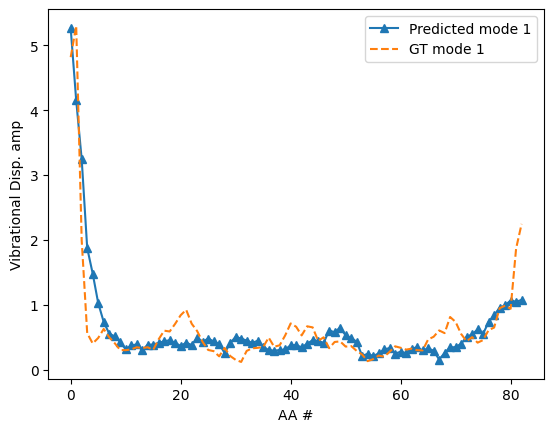

PR Seq:
MSSGSSGNAKLKTLLELLSLFSLAAGRPVSEELSRLVELEKNVQELEGAPGSENELSLEAGFKRLRIVKLKDLDPLKLSGPSS
GT Seq:
TYQCLKGTGENYRGNVAVTVSGHTCQHWSAQTPHTHNRTPENFPSKNLDENYCRNPDGKRAPWCHTTNSQVRWEYCKIPSCDS
Recovery ratio: 0.04819277108433735

Save conditioning...

torch.Size([1, 83])

Save PP pred conditioning...

torch.Size([1, 83])
Mode 1 ρ: 0.8886076137246683


Ave ρ over modes: 0.8886076137246683

Save GT AA

seq len: 83

Save PR AA

seq len: 83

Plot the PD comparison...



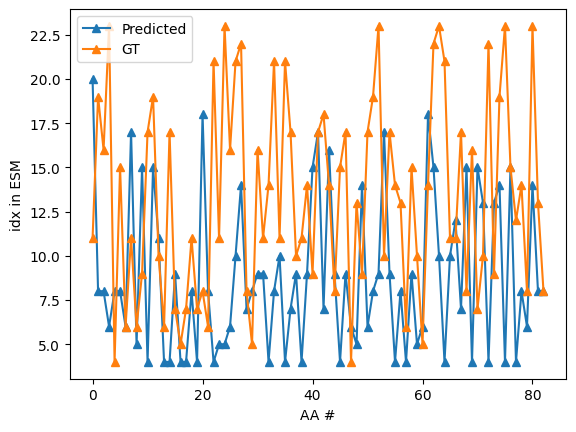


Folding the predicted AA...

Writing FASTA file:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
Now run OmegaFold.... on device=cuda:0


INFO:root:Downloading weights from https://helixon.s3.amazonaws.com/release1.pt to /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:Predicting 1th chain in /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:83 residues in this chain.
INFO:root:Finished prediction in 24.13 seconds.
INFO:root:Saving prediction to /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb




Show the folded structure...
Only use this in a non-silent running...


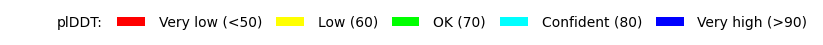

3Dmol.js failed to load for some reason. Please check your browser console for error messages.



Ana. secondary structure...
AA:           MSSGSSGNAKLKTLLELLSLFSLAAGRPVSEELSRLVELEKNVQELEGAPGSENELSLEAGFKRLRIVKLKDLDPLKLSGPSS
AA from DSSP: MSSGSSGNAKLKTLLELLSLFSLAAGRPVSEELSRLVELEKNVQELEGAPGSENELSLEAGFKRLRIVKLKDLDPLKLSGPSS
Q8:           ~~THHHHHHHHHHHHHHHHHHHHHHT~~HHHHHHHHHHHHHHHHHHHH~TT~~SS~~HHHHHHHHT~~~GGG~~HHHHS~~~~
Q3:           CCCHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHCCCCHHHCCHHHHCCCCC



Processing Picked #: Input 1 -- Design 2


This supposed to be the 2th among the best



NMS Err based on PP: 25.46183204650879
Idx in PD batch: 8
Plot the PP comparison...


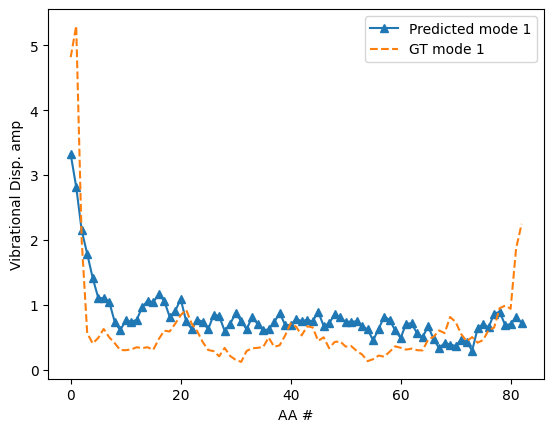

PR Seq:
MIQKKKVKVEIKEKKFQAILGDATALTFLIDGNNGFLSKILLLGGQTIEGVPGLTLSQTDRDALLRDLDILCVLSEISKKIYK
GT Seq:
TYQCLKGTGENYRGNVAVTVSGHTCQHWSAQTPHTHNRTPENFPSKNLDENYCRNPDGKRAPWCHTTNSQVRWEYCKIPSCDS
Recovery ratio: 0.04819277108433735

Save conditioning...

torch.Size([1, 83])

Save PP pred conditioning...

torch.Size([1, 83])
Mode 1 ρ: 0.7785690903887509


Ave ρ over modes: 0.7785690903887509

Save GT AA

seq len: 83

Save PR AA

seq len: 83

Plot the PD comparison...



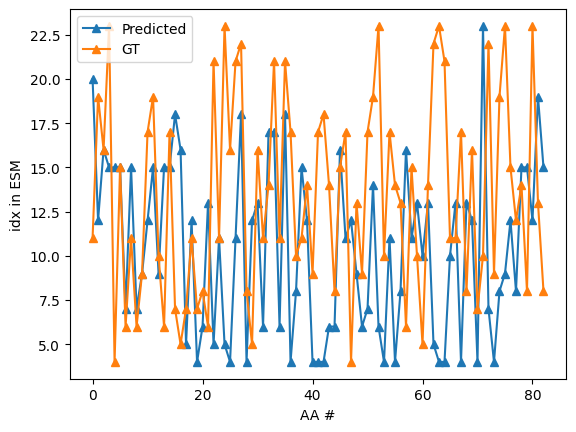


Folding the predicted AA...

Writing FASTA file:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
Now run OmegaFold.... on device=cuda:0


INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:Predicting 1th chain in /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:83 residues in this chain.
INFO:root:Finished prediction in 24.22 seconds.
INFO:root:Saving prediction to /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb




Show the folded structure...
Only use this in a non-silent running...


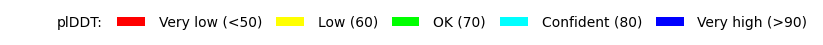

3Dmol.js failed to load for some reason. Please check your browser console for error messages.



Ana. secondary structure...
AA:           MIQKKKVKVEIKEKKFQAILGDATALTFLIDGNNGFLSKILLLGGQTIEGVPGLTLSQTDRDALLRDLDILCVLSEISKKIYK
AA from DSSP: MIQKKKVKVEIKEKKFQAILGDATALTFLIDGNNGFLSKILLLGGQTIEGVPGLTLSQTDRDALLRDLDILCVLSEISKKIYK
Q8:           ~~~~~~~~~~~~HHHHHHHHH~HHHHHIIIII~~~HHHHHHHTTT~~GGGSTT~~~~HHHHHHHHHHHHHHHHHHHHHHHHH~
Q3:           CCCCCCCCCCCCHHHHHHHHHCHHHHHCCCCCCCCHHHHHHHCCCCCHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHC



Processing Picked #: Input 1 -- Design 3


This supposed to be the 1th among the worst



NMS Err based on PP: 52.43220520019531
Idx in PD batch: 0
Plot the PP comparison...


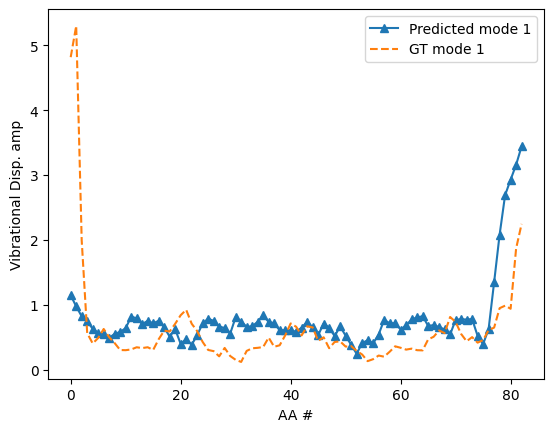

PR Seq:
MGIYTRLQLIPDNAKSSKISVKDGKDFGRGAGVSQGAVVFDIGPDKATLKNILVRSVKERFGKKAGEVQIRDDDLLEEHHHHH
GT Seq:
TYQCLKGTGENYRGNVAVTVSGHTCQHWSAQTPHTHNRTPENFPSKNLDENYCRNPDGKRAPWCHTTNSQVRWEYCKIPSCDS
Recovery ratio: 0.04819277108433735

Save conditioning...

torch.Size([1, 83])

Save PP pred conditioning...

torch.Size([1, 83])
Mode 1 ρ: 0.3677393557804262


Ave ρ over modes: 0.3677393557804262

Save GT AA

seq len: 83

Save PR AA

seq len: 83

Plot the PD comparison...



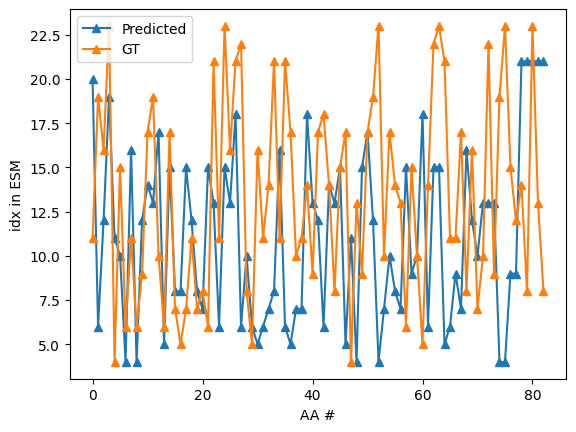


Folding the predicted AA...

Writing FASTA file:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
Now run OmegaFold.... on device=cuda:0


INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:Predicting 1th chain in /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:83 residues in this chain.
INFO:root:Finished prediction in 24.47 seconds.
INFO:root:Saving prediction to /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb




Show the folded structure...
Only use this in a non-silent running...


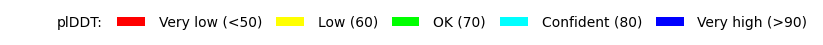

3Dmol.js failed to load for some reason. Please check your browser console for error messages.



Ana. secondary structure...
AA:           MGIYTRLQLIPDNAKSSKISVKDGKDFGRGAGVSQGAVVFDIGPDKATLKNILVRSVKERFGKKAGEVQIRDDDLLEEHHHHH
AA from DSSP: MGIYTRLQLIPDNAKSSKISVKDGKDFGRGAGVSQGAVVFDIGPDKATLKNILVRSVKERFGKKAGEVQIRDDDLLEEHHHHH
Q8:           ~~~~~EEEEEE~SSS~EEEEEE~~S~~~TT~~~~~~~EEE~~~S~HHHHHHHHHHHHHHHH~~~GGG~~~~GGGS~~~~~~~~
Q3:           CCCCCEEEEEECCCCCEEEEEECCCCCCCCCCCCCCCEEECCCCCHHHHHHHHHHHHHHHHCCCHHHCCCCHHHCCCCCCCCC



Processing Picked #: Input 1 -- Design 4


This supposed to be the 2th among the worst



NMS Err based on PP: 46.56159973144531
Idx in PD batch: 13
Plot the PP comparison...


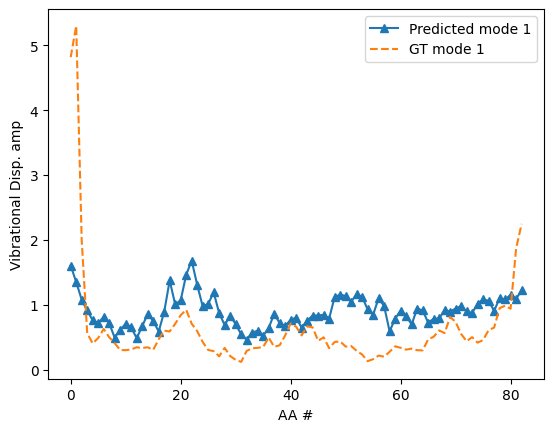

PR Seq:
MSLQAALVYVEVLEKLTNEFGGEANTFQLLLRVNQQQIVIKAIVRLENKDVGGVSNDLVNEAFEIIKNFVRVLKDSLRIEGVA
GT Seq:
TYQCLKGTGENYRGNVAVTVSGHTCQHWSAQTPHTHNRTPENFPSKNLDENYCRNPDGKRAPWCHTTNSQVRWEYCKIPSCDS
Recovery ratio: 0.03614457831325301

Save conditioning...

torch.Size([1, 83])

Save PP pred conditioning...

torch.Size([1, 83])
Mode 1 ρ: 0.48890880795591835


Ave ρ over modes: 0.48890880795591835

Save GT AA

seq len: 83

Save PR AA

seq len: 83

Plot the PD comparison...



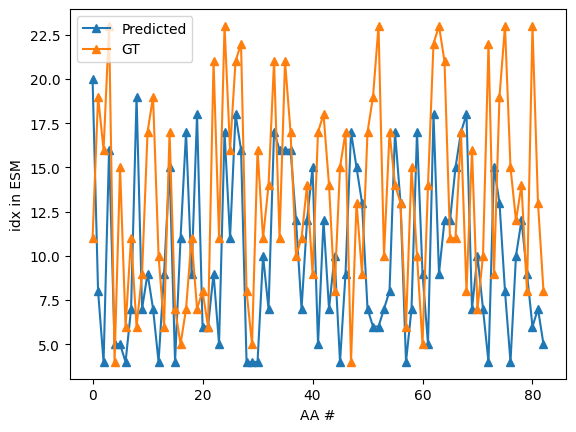


Folding the predicted AA...

Writing FASTA file:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
Now run OmegaFold.... on device=cuda:0


INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:Predicting 1th chain in /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.fasta
INFO:root:83 residues in this chain.
INFO:root:Finished prediction in 24.50 seconds.
INFO:root:Saving prediction to /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  /content/wk_dir/PD_LAST_APS_26560_PP_LAST_APS_16800_sc_1.0_1.0/Temp_.pdb




Show the folded structure...
Only use this in a non-silent running...


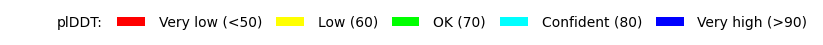

3Dmol.js failed to load for some reason. Please check your browser console for error messages.



Ana. secondary structure...
AA:           MSLQAALVYVEVLEKLTNEFGGEANTFQLLLRVNQQQIVIKAIVRLENKDVGGVSNDLVNEAFEIIKNFVRVLKDSLRIEGVA
AA from DSSP: MSLQAALVYVEVLEKLTNEFGGEANTFQLLLRVNQQQIVIKAIVRLENKDVGGVSNDLVNEAFEIIKNFVRVLKDSLRIEGVA
Q8:           ~HHHHHHHHHHHHHHHHHHT~S~~~HHHHHHHHHHHHHHHHHHHHHHHS~~SS~~HHHHHHHHHHHHHHHHHHHHHHHHHT~~
Q3:           CHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCC



In [10]:
#@title ### 1.2. Sampling

print (f"Working mode: \n"+
    CKeys['Working_Mode']
)

#

if CKeys['Working_Mode']=='Sampling':

    # ONLY collect the mode shape
    # Note, no padding and no normalization

    # if sampling over the whole set
    Joint_Sampling_List = range(len(PD_df_test))

    # A simple demo: sampling only the one input condition from the test set
    Joint_Sampling_List = [1]

    PD_test_set_condition_list = UPack.build_XCond_list_from_df(
        PD_df_test,
        PD_DataKeys['X_Key'],
        pick_id_list=Joint_Sampling_List,
    )
    #
    PD_test_set_AA_list = UPack.build_AA_list_from_df(
        PD_df_test,
        AA_key='AA',
        pick_id_list=Joint_Sampling_List,
    )

#

if CKeys['Debug_Sampling']==1:

    print (PD_test_set_condition_list[0].shape)
    print (PD_DataKeys['X_Key'][0])
    print (
        PD_df_test[PD_DataKeys['X_Key'][0]].values[0].shape
    )
    # print (PD_test_set_condition_list[0][0])
    # print (PD_df_test[PD_DataKeys['X_Key'][0]].values[0])

    print (PD_test_set_AA_list[0])

print (PD_ck_info['completed_updating_steps'])
print (PP_ck_info['completed_updating_steps'])

print (PD_CKeys['Resume_from_where'])
print (PP_CKeys['Resume_from_where'])

print (CKeys['wk_dir'])

detailed_resut_path = CKeys['wk_dir']+\
    f"PD_{PD_CKeys['Resume_from_where']}_APS_{PD_ck_info['completed_updating_steps']}_PP_{PP_CKeys['Resume_from_where']}_APS_{PP_ck_info['completed_updating_steps']}_"+\
    f"sc_{str(CKeys['PD_cond_scal'])}_{CKeys['PP_cond_scal']}"
print (detailed_resut_path )

print (
    f"\n\n\nNow, try on {len(Joint_Sampling_List)} input conditions\n"+\
    f"For each input, \nProteinDesigner Will design {CKeys['n_try_w_PD']} candidates\n"+\
    f"ProteinPredictor will evaluate them and pick the best {CKeys['n_keep_w_PP']} and the worst {CKeys['n_keep_w_PP']} samples.\n"+\
    f"The detailed results can be found in the following path:\n"+\
    f"{detailed_resut_path}\n"+\
    f"Enjoy!\n\n\n"
)


if CKeys['Working_Mode']=='Sampling':
    #
    SPack.joint_sampling_w_PD_and_PP(
        # 1. model
        PD_wk_ProteinDesigner,
        PP_wk_ProteinPredictor,
        # 2. data
        PD_test_set_condition_list, # input as a list of NMS vecs
        PD_test_set_AA_list=PD_test_set_AA_list,   # whether GT is provided
        PD_DataKeys=PD_DataKeys,
        # 3. control param
        n_try_w_PD = CKeys['n_try_w_PD'], # 20,  # For PD, try this number times as a batch
        n_keep_w_PP_goo = CKeys['n_keep_w_PP'], # 2,   # Use PP to pick the top this_number samples
        n_keep_w_PP_bad = CKeys['n_keep_w_PP'], # 2,   # Use PP to pick the top this_number samples
        PD_cond_scal = CKeys['PD_cond_scal'], # 7.5,
        PP_cond_scal = CKeys['PP_cond_scal'], # 7.5,
        # 4. outputs
        joint_sampling_dir = CKeys['wk_dir']+\
        f"PD_{PD_CKeys['Resume_from_where']}_APS_{PD_ck_info['completed_updating_steps']}_PP_{PP_CKeys['Resume_from_where']}_APS_{PP_ck_info['completed_updating_steps']}_"+\
        f"sc_{str(CKeys['PD_cond_scal'])}_{CKeys['PP_cond_scal']}",
        #
        joint_sampling_prefix = f"TestSet_", # 3. on postprocessing
        #
        IF_plot_PP = True,
        IF_showfig = (CKeys['Debug']==1), # True,
        IF_save_pred_pack = True,
        IF_plot_PD = (CKeys['Debug']==1), # True,
        IF_fold_seq = True,
        IF_show_foldding = (CKeys['Debug']==1), # True,
        IF_DSSP = True,
        # 5. others
        device = device,
    )

